In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/attacked-text/attacked_text.csv
/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv


In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 3.44 MiB/s, done.


In [3]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [4]:
import os, sys, argparse, time

import numpy as np
from transformers import AutoTokenizer
from mersenne import mersenne_rng

import pyximport
pyximport.install(reload_support=True, language_level=sys.version_info[0],
                  setup_args={'include_dirs':np.get_include()})
from levenshtein import levenshtein

def permutation_test(tokens,key,n,k,vocab_size,n_runs=100):
    rng = mersenne_rng(key)
    xi = np.array([rng.rand() for _ in range(n*vocab_size)], dtype=np.float32).reshape(n,vocab_size)
    test_result = detect(tokens,n,k,xi)

    p_val = 0
    for run in range(n_runs):
        xi_alternative = np.random.rand(n, vocab_size).astype(np.float32)
        null_result = detect(tokens,n,k,xi_alternative)

        # assuming lower test values indicate presence of watermark
        p_val += null_result <= test_result

    return (p_val+1.0)/(n_runs+1.0)


def detect(tokens,n,k,xi,gamma=0.0):
    m = len(tokens)
    n = len(xi)

    A = np.empty((m-(k-1),n))
    for i in range(m-(k-1)):
        for j in range(n):
            A[i][j] = levenshtein(tokens[i:i+k],xi[(j+np.arange(k))%n],gamma)

    return np.min(A)


In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-cpython-310/kaggle/working/watermark/demo/levenshtein.c:1205:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
from tqdm import tqdm
import pandas as pd

def main():
    # Read data from CSV using pandas
    data = pd.read_csv("/kaggle/input/attacked-text/attacked_text.csv")
    # Combine filtered data
    split_point1 = int(len(data) / 3)
    split_point2 = split_point1 * 2
    split_point3 = 100
    part1 = data.iloc[:35] # First part
    part2 = data.iloc[35:69]  # Second part
    part3 = data.iloc[69:100]  # Third part (might be slightly bigger)
    # Load pre-trained tokenizer (replace with your desired tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    # Progress bar with tqdm
    results = []
    for index, row in tqdm(part2.iterrows(), total=len(part2)):
        text = row["Attacked Text"]  # Assuming "Attacked Text" is the column containing text data
        actual_label = "watermarked" # Assuming "label" is the column containing actual label

        # Tokenize the text
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=2048).numpy()[0]

        t0 = time.time()
        pval = permutation_test(tokens, 42, 256, len(tokens), len(tokenizer))
        label = "watermarked" if pval <= 0.01 else "unwatermarked"
        results.append({"text": text, "p-value": pval, "label": label, "actual_label": actual_label})
        print(f"Row {index+1} - p-value: {pval:.4f}, label: {label} (elapsed time: {time.time()-t0:.2f}s)")

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)
#     df_results.head(2)
    # Save the DataFrame (optional)
    df_results.to_csv("permutation_test_results_zerowidth.csv", index=False)
if __name__ == '__main__':
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

  3%|▎         | 1/34 [09:02<4:58:20, 542.43s/it]

Row 36 - p-value: 0.0198, label: unwatermarked (elapsed time: 542.39s)


  6%|▌         | 2/34 [17:44<4:42:49, 530.29s/it]

Row 37 - p-value: 0.3069, label: unwatermarked (elapsed time: 521.80s)


  9%|▉         | 3/34 [26:44<4:36:17, 534.76s/it]

Row 38 - p-value: 0.2475, label: unwatermarked (elapsed time: 540.06s)


 12%|█▏        | 4/34 [37:21<4:47:35, 575.17s/it]

Row 39 - p-value: 0.0891, label: unwatermarked (elapsed time: 637.11s)


 15%|█▍        | 5/34 [46:23<4:32:18, 563.38s/it]

Row 40 - p-value: 0.1782, label: unwatermarked (elapsed time: 542.48s)


 18%|█▊        | 6/34 [55:59<4:24:48, 567.43s/it]

Row 41 - p-value: 0.2772, label: unwatermarked (elapsed time: 575.29s)


 21%|██        | 7/34 [1:06:44<4:26:43, 592.73s/it]

Row 42 - p-value: 0.1980, label: unwatermarked (elapsed time: 644.82s)


 24%|██▎       | 8/34 [1:15:44<4:09:34, 575.95s/it]

Row 43 - p-value: 0.1089, label: unwatermarked (elapsed time: 540.01s)


 26%|██▋       | 9/34 [1:25:05<3:58:05, 571.43s/it]

Row 44 - p-value: 0.3069, label: unwatermarked (elapsed time: 561.50s)


 29%|██▉       | 10/34 [1:34:03<3:44:25, 561.08s/it]

Row 45 - p-value: 0.0990, label: unwatermarked (elapsed time: 537.90s)


 32%|███▏      | 11/34 [1:45:10<3:47:31, 593.52s/it]

Row 46 - p-value: 0.1980, label: unwatermarked (elapsed time: 667.07s)


 35%|███▌      | 12/34 [1:54:37<3:34:42, 585.56s/it]

Row 47 - p-value: 0.2970, label: unwatermarked (elapsed time: 567.36s)


 38%|███▊      | 13/34 [2:03:13<3:17:34, 564.49s/it]

Row 48 - p-value: 0.0198, label: unwatermarked (elapsed time: 515.98s)


 41%|████      | 14/34 [2:14:26<3:19:05, 597.28s/it]

Row 49 - p-value: 0.0495, label: unwatermarked (elapsed time: 673.04s)


 44%|████▍     | 15/34 [2:23:55<3:06:26, 588.77s/it]

Row 50 - p-value: 0.1188, label: unwatermarked (elapsed time: 569.04s)


 47%|████▋     | 16/34 [2:34:20<2:59:50, 599.47s/it]

Row 51 - p-value: 0.6733, label: unwatermarked (elapsed time: 624.31s)


 50%|█████     | 17/34 [2:43:36<2:46:12, 586.61s/it]

Row 52 - p-value: 0.0099, label: watermarked (elapsed time: 556.71s)


 53%|█████▎    | 18/34 [2:55:10<2:45:01, 618.87s/it]

Row 53 - p-value: 0.2574, label: unwatermarked (elapsed time: 693.96s)


 56%|█████▌    | 19/34 [3:05:48<2:36:07, 624.51s/it]

Row 54 - p-value: 0.3465, label: unwatermarked (elapsed time: 637.64s)


 59%|█████▉    | 20/34 [3:15:17<2:21:48, 607.75s/it]

Row 55 - p-value: 0.0297, label: unwatermarked (elapsed time: 568.69s)


 62%|██████▏   | 21/34 [3:26:19<2:15:14, 624.19s/it]

Row 56 - p-value: 0.4851, label: unwatermarked (elapsed time: 662.51s)


 65%|██████▍   | 22/34 [3:36:53<2:05:24, 627.00s/it]

Row 57 - p-value: 0.5347, label: unwatermarked (elapsed time: 633.56s)


 68%|██████▊   | 23/34 [3:47:13<1:54:35, 625.03s/it]

Row 58 - p-value: 0.0198, label: unwatermarked (elapsed time: 620.44s)


 71%|███████   | 24/34 [3:57:54<1:44:57, 629.74s/it]

Row 59 - p-value: 0.1188, label: unwatermarked (elapsed time: 640.70s)


 74%|███████▎  | 25/34 [4:10:28<1:40:02, 666.91s/it]

Row 60 - p-value: 0.7426, label: unwatermarked (elapsed time: 753.63s)


 76%|███████▋  | 26/34 [4:20:12<1:25:38, 642.25s/it]

Row 61 - p-value: 0.1881, label: unwatermarked (elapsed time: 584.72s)


 79%|███████▉  | 27/34 [4:32:15<1:17:43, 666.25s/it]

Row 62 - p-value: 0.1584, label: unwatermarked (elapsed time: 722.23s)


 82%|████████▏ | 28/34 [4:43:49<1:07:28, 674.71s/it]

Row 63 - p-value: 0.0495, label: unwatermarked (elapsed time: 694.44s)


 85%|████████▌ | 29/34 [4:55:21<56:39, 679.90s/it]  

Row 64 - p-value: 0.3267, label: unwatermarked (elapsed time: 692.02s)


 88%|████████▊ | 30/34 [5:06:14<44:47, 671.80s/it]

Row 65 - p-value: 0.0693, label: unwatermarked (elapsed time: 652.88s)


 91%|█████████ | 31/34 [5:16:46<32:59, 659.76s/it]

Row 66 - p-value: 0.1584, label: unwatermarked (elapsed time: 631.67s)


 94%|█████████▍| 32/34 [5:27:28<21:49, 654.59s/it]

Row 67 - p-value: 0.0693, label: unwatermarked (elapsed time: 642.51s)


 97%|█████████▋| 33/34 [5:39:46<11:19, 679.46s/it]

Row 68 - p-value: 0.4950, label: unwatermarked (elapsed time: 737.49s)


100%|██████████| 34/34 [5:49:38<00:00, 617.01s/it]

Row 69 - p-value: 0.0198, label: unwatermarked (elapsed time: 592.05s)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


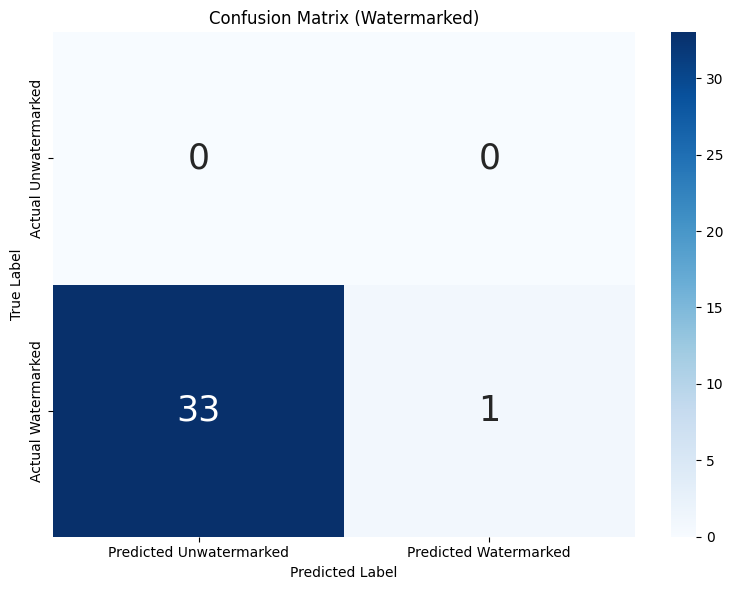


Classification Metrics:
Accuracy: 2.9412
F1-score: 5.7143
Precision: 100.0000
Recall: 2.9412


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['actual_label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
      # Define custom labels for the confusion matrix

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Watermarked)')
    plt.xticks([0.5, 1.5], ['Predicted Unwatermarked', 'Predicted Watermarked'])
    plt.yticks([0.5, 1.5], ['Actual Unwatermarked', 'Actual Watermarked'])    
    plt.tight_layout()
    plt.show()
    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")


In [8]:
def evaluate_misclassifications(file_path):
    # Evaluates the average absolute difference between misclassified p-values and the threshold (0.1) for watermarked images.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for misclassified watermarked images
    misclassified_watermarked = df[(df['label'] != df['actual_label']) & (df['actual_label'] == 'watermarked')]

    # Check if there are any misclassified watermarked images
    if len(misclassified_watermarked) == 0:
        print("No misclassified watermarked images found.")
        return None

    # Calculate absolute difference between misclassified p-values and the threshold (0.1)
    abs_diff = np.abs(misclassified_watermarked['p-value'] - 0.1)

    # Calculate average absolute difference
    average_diff = np.mean(abs_diff)

    return average_diff

# Specify the file path
file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"

# Evaluate misclassifications
average_diff = evaluate_misclassifications(file_path)

if average_diff is not None:
    print(f"Average absolute difference for misclassified watermarked images: {average_diff:.4f}")


Average absolute difference for misclassified watermarked images: 0.1542


In [9]:
def get_incorrect_samples(file_path):
   
    # Extracts all samples from a CSV file where 'label' and 'actual_label' differ.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for rows where label doesn't equal actual_label
    incorrect_samples = df[df['label'] != df['actual_label']]
    incorrect_samples = incorrect_samples.sort_values(by='actual_label')

    return incorrect_samples

file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"
incorrect_df = get_incorrect_samples(file_path)


incorrect_df.head(len(incorrect_df))

,text,p-value,label,actual_label
0,The president'‌s la‍wyer has ‍die​‌d a‌​t a ve...,0.019802,unwatermarked,watermarked
31,Th‍e finances we​re f‌or s‌erv​ic‍e​ prov‌isio...,0.069307,unwatermarked,watermarked
30,Anthrax‍ is more commo​n in animal‍s‍ than‌‍ p...,0.158416,unwatermarked,watermarked
29,You‍ should fil​e a suit agai​ns‍t ‍that compa...,0.069307,unwatermarked,watermarked
28,Gover​nme‌nt h​‍as‌ decided‌ ​to incr‍e‍ase‌​ ...,0.326733,unwatermarked,watermarked
27,Vo​te​ rigging ‍should b​e condemned in the co...,0.049505,unwatermarked,watermarked
26,‌Some‌ p‍eople‍ s​t​eal b‌​ecause ‍​they ​do n...,0.158416,unwatermarked,watermarked
25,Some​ of the disease​​d ​leaves hav​e‌ dr‌ied‌...,0.188119,unwatermarked,watermarked
24,Many ch​ildr‌en f‌ail​ to comp​lete school‍ be...,0.742574,unwatermarked,watermarked
23,‍I​t'‍s two days‌ to‌ ‍the 1st National H‌e‍‌a...,0.118812,unwatermarked,watermarked
